In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import print_function, absolute_import, division

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from GomokuBoard import GomokuBoard
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt

In [32]:
A,B,C,D,E,F,G,H,I, J, K, L, M, N, O, P, Q, R, S, T, U = \
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK, WHITE, EDGES = 0,1,2

from [Yixin vs Rudolf Dupszki](https://www.aiexp.info/ai-vs-human-gomoku-2.html), we have a nice threat sequence:

- Round1: Swap2, two more, +, Yixin white. 
- Round2: Swap2, two more, +, Yixin black.

In [45]:
# Round 1
# stones=gt.string_to_stones('l13k12m11n14o13k11j12k13k10j10i9j9j8k7h11l8i11m9n10m7l9l7n7m8m6k6n9n6k9i7j7k5')
# Round 2
stones=gt.string_to_stones('e10g8g5f5f6e7f7f8e8g9h10d9g10f10h8h9i9g7e9j8h11i12e11e12g11f11f12e13g13h14i10g14j9k8i8k4i7')

In [46]:
b = GomokuBoard(heuristics=Heuristics(kappa=3), stones=stones, disp_width=10)

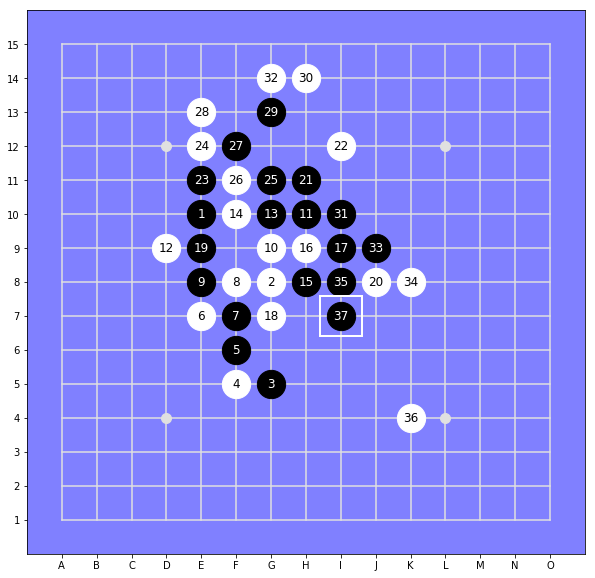

In [47]:
b.display()

# Reading psq files

In [49]:
file = open("games/0_0_8_2.psq", "r")
lines = [l.strip().split(',') for l in file]
stones = [(chr(64+int(x)), int(y)) for x,y,_ in lines[1:-4]]

In [50]:
print(stones)

[('J', 20), ('K', 20), ('J', 19), ('K', 19), ('J', 18), ('K', 18), ('J', 17), ('K', 17), ('K', 16), ('J', 16), ('M', 16), ('I', 15), ('H', 14), ('L', 15), ('H', 13), ('K', 15), ('J', 15), ('I', 14), ('L', 14), ('M', 17), ('I', 13), ('L', 18), ('M', 19), ('N', 18), ('L', 16), ('N', 16), ('O', 15), ('N', 17), ('N', 19), ('O', 17), ('L', 17), ('M', 18), ('O', 18), ('P', 17), ('Q', 17), ('N', 15), ('N', 14), ('O', 16), ('L', 19), ('M', 14), ('L', 13), ('Q', 18)]


In [51]:
b = GomokuBoard(heuristics=Heuristics(kappa=3), stones=stones, disp_width=10, N=20)

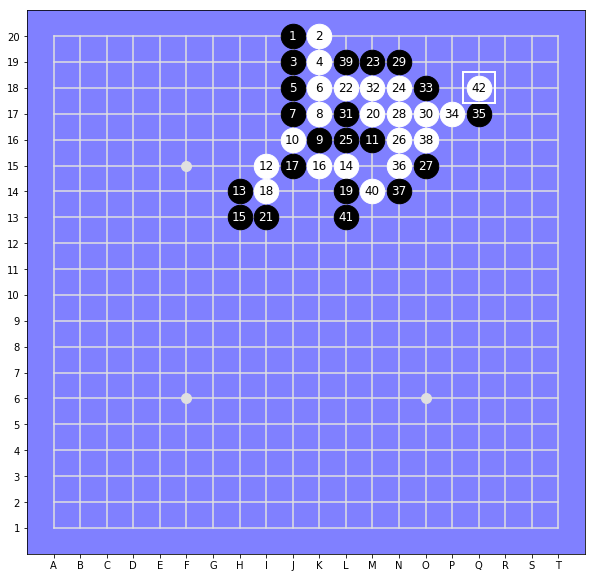

In [52]:
b.display()

---
# Gomocup 2018 data for upload to GCP
Read and concatenate the games to larger csv files

In [117]:
def read_psq(filename):
    file = open(filename, "r")

    blob=file.read()
    lines=blob.split("\n")
    blob = blob.replace(",",";")

    head = lines[0]
    game = lines[1:-5]
    tail = lines[-5:]

    coords = [m.split(',') for m in game]
    stones = [(chr(int(x)+64),int(y)) for x,y,_ in coords]
    game = gt.stones_to_string(stones)    
    
    headers = [w.strip() for w in head.split(",")]

    filetype, dimensions=headers[0].split()

    assert(filetype=="Piskvorky")
    
    dim_x, dim_y = dimensions.split('x')
    dim_x, dim_y = int(dim_x), int(dim_y)

    h3, h4 = headers[1:]

    player1, player2 = tail[:2]

    t3=tail[2]
    t4, tournament = tail[3].split(",")

    return {
        'filetype': filetype,
        'dim_x': dim_x,
        'dim_y': dim_y,
        'h3': h3,
        'h4': h4,
        'player1': player1,
        'player2': player2,
        'game': game,
        't3': t3,
        't4': t4,
        'tournament': tournament,
        'blob': blob
    }

In [176]:
res = read_psq("games/0_0_1_2.psq")
res

{'filetype': 'Piskvorky',
 'dim_x': 20,
 'dim_y': 20,
 'h3': '11:11',
 'h4': '0',
 'player1': 'RENJUSOLVER.F.zip',
 'player2': 'YIXIN18.zip',
 'game': 'j20k20j19k19j18k18j17k17k16j16m16i15h14l15h13k15j15i14l14m17n18i13i12o16o17j14l16k13l12h15g16n15n16j11h12k12h11h10j13k11k14g10i10m11l11k9k10l10j8m9j12j9l9m12m15p18g12f12m10p15i16m14l13h17p17q14n17o12o13r15r17q17p13s12r13q15o15q16q18q13',
 't3': '-1',
 't4': '1',
 'tournament': 'Freestyle1',
 'blob': 'Piskvorky 20x20; 11:11; 0\n10;20;0\n11;20;0\n10;19;0\n11;19;0\n10;18;0\n11;18;0\n10;17;0\n11;17;0\n11;16;0\n10;16;0\n13;16;0\n9;15;39664\n8;14;17272\n12;15;12787\n8;13;19600\n11;15;24444\n10;15;19225\n9;14;27320\n12;14;19054\n13;17;33618\n14;18;18678\n9;13;6068\n9;12;18522\n15;16;13177\n15;17;18193\n10;14;23539\n12;16;36\n11;13;106326\n12;12;17615\n8;15;19303\n7;16;17647\n14;15;31476\n14;16;17194\n10;11;31290\n8;12;17147\n11;12;20241\n8;11;16615\n8;10;21\n10;13;16568\n11;11;35868\n11;14;37\n7;10;20\n9;10;16131\n13;11;10193\n12;11;16052\n11;

In [121]:
import pandas as pd

In [167]:
df = pd.DataFrame()

#### This might take a while!!
especially, 'Fastgame' takes about half an hour or so

In [170]:
tournaments = ['Fastgame', 'Freestyle1', 'Freestyle2', 'Freestyle3', 'Freestyle4', 'Standard']

directory='/Users/wgiersche/Downloads/gomocup2018results/'+'Standard'

files = [f for f in os.listdir(directory) if '.psq' in f]
for file in files:
    res = read_psq(directory + "/" + file)
    df = df.append(res, ignore_index=True)

In [171]:
df.to_csv('Standard.csv')

In [175]:
list(df.head()['game'])

['j20k20j19k19j18k18j17k17k16j16m16l18m19l19l15i18m14l20n13',
 'j20k20j19k19j18k18j17k17k16j16m16l18i15l19l15i18m14l20n13',
 'j20k20j19k19j18k18j17k17k16j16m16l18h9m19i15n20',
 'j20k20j19k19j18k18j17k17k16j16m16l18i15l19m19l20l17m18n17l15n18l14n16n19n15l16n14',
 'j20k20j19k19j18k18j17k17k16j16m16l18h19m19i18n20']